<a href="https://colab.research.google.com/github/feltri08/Clasificacion-imagenes-de-alzheimer/blob/main/Proyecto_terminado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://raw.githubusercontent.com/diegortega98/AIproyect/main/aiportadaproyect.png" style="width:1800px;">


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**<h3>Estas son las librerias que se utilizaran para la ejecución de todo el proyecto</h3>**

In [ ]:
#Librerias 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from tensorflow import keras
import tensorflow as tf


 **CLASES DEL DATASET**

Las clases del dataset se definen de la siguiente forma:


1.  NonDemented
2.  ModerateDemented
3.  MildDemented
4.  VeryMildDemented

El dataset a trabajar ya tiene las particiones de Train y Test.

Acontinuacion cargaremos los datos de Train para cada una de las clases: 

   

In [ ]:
#creamos dos listas para empezar a guardar las imagenes 
X_train=[] #lista con caracteristicas (imagenes)
y_train=[] #lista con etiquetas
X_train_Original=[]
y_train_Original=[]
dim = (200,200)  #Dimensiones para las imagenes que trabajaremos

In [ ]:
#especifica la ruta y lee el nombre de los documentos dentro de dicha carpeta para la primera clase
path_classes = '/content/drive/My Drive/ProyectoInteligencia/Alzheimer_s Dataset/train/NonDemented'
classes_names = os.listdir(path_classes)

#carga la imagenes
for i in classes_names:
  img = cv2.imread(path_classes+'/'+i)
  img = cv2.resize(img, dim)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  X_train.append(gray.flatten()) #guarda la imagen en la lista 
  y_train.append(0)  #0 NonDemented
  X_train_Original.append(gray.flatten()) #guarda la imagen en la lista 
  y_train_Original.append(0)  #0 NonDemented

<br>
<h3>Al tener tan pocas imagenes de la siguiente clase se procedera a rotarlas y reflejarlas para que no haya tanto desbalance de clases y pueda funcionar de una mejor manera.</h3>
<br>

In [ ]:
#especifica la ruta y lee el nombre de los documentos dentro de dicha carpeta para la segunda clase
path_classes = '/content/drive/My Drive/ProyectoInteligencia/Alzheimer_s Dataset/train/ModerateDemented'
classes_names = os.listdir(path_classes)

#carga la imagenes
F=0
temp=[]
for i in classes_names:
  F=F+1
  img = cv2.imread(path_classes+'/'+i)
  img = cv2.resize(img, dim)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  temp.append(gray)
  X_train.append(gray.flatten()) #guarda la imagen en la lista 
  y_train.append(1)  #1 ModerateDemented
  X_train_Original.append(gray.flatten()) #guarda la imagen en la lista 
  y_train_Original.append(1)  #1 ModerateDemented
  
  #EFECTO ESPEJO
  imagenEspejo=np.fliplr(gray)
  X_train.append(imagenEspejo.flatten()) #guarda la imagen en la lista 
  y_train.append(1)  #1 ModerateDemented

#ROTACIÓN
width=200
height=200

for j in range(F):
  for k in range(20):
    rotationMatrix = cv2.getRotationMatrix2D((width/2, height/2), k/2, 1)
    rotationMatrix2 = cv2.getRotationMatrix2D((width/2, height/2), -k/2, 1)

    rotatedImage = cv2.warpAffine(temp[j], rotationMatrix, (width, height))
    rotatedImage2 = cv2.warpAffine(temp[j], rotationMatrix, (width, height))

    X_train.append(rotatedImage.flatten())
    X_train.append(rotatedImage2.flatten())

    y_train.append(1)  #1 ModerateDemented
    y_train.append(1)  #1 ModerateDemented

In [ ]:
#especifica la ruta y lee el nombre de los documentos dentro de dicha carpeta para la tercera clase
path_classes = '/content/drive/My Drive/ProyectoInteligencia/Alzheimer_s Dataset/train/MildDemented'
classes_names = os.listdir(path_classes)

#carga la imagenes
for i in classes_names:
  img = cv2.imread(path_classes+'/'+i)
  img = cv2.resize(img, dim)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  X_train.append(gray.flatten()) #guarda la imagen en la lista 
  y_train.append(2)  #2 MildDemented
  X_train_Original.append(gray.flatten()) #guarda la imagen en la lista 
  y_train_Original.append(2)  #2 MildDemented

  #EFECTO ESPEJO
  imagenEspejo=np.fliplr(gray)
  X_train.append(imagenEspejo.flatten()) #guarda la imagen en la lista de forma reflejada 
  y_train.append(2)  #2 MildDemented

In [ ]:
#especifica la ruta y lee el nombre de los documentos dentro de dicha carpeta para la cuarta clase
path_classes = '/content/drive/My Drive/ProyectoInteligencia/Alzheimer_s Dataset/train/VeryMildDemented'
classes_names = os.listdir(path_classes)

#carga la imagenes
for i in classes_names:
  img = cv2.imread(path_classes+'/'+i)
  img = cv2.resize(img, dim)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  X_train.append(gray.flatten()) #guarda la imagen en la lista 
  y_train.append(3)  #3 VeryMildDemented
  X_train_Original.append(gray.flatten()) #guarda la imagen en la lista 
  y_train_Original.append(3)  #3 VeryMildDemented

<br>
<h2>Para poder realizar las estimaciones necesitaremos permutar los datos de train.</h2>
<br>

In [ ]:
perm_Original = np.random.permutation(range(len(X_train_Original)))
X_train_Original=np.r_[X_train_Original]
y_train_Original=np.r_[y_train_Original]
X_train_Original=X_train_Original[perm_Original]
y_train_Original=y_train_Original[perm_Original]
print(X_train_Original.shape)

(5121, 40000)


In [ ]:
perm = np.random.permutation(range(len(X_train)))
X_train=np.r_[X_train]
y_train=np.r_[y_train]
X_train=X_train[perm]
y_train=y_train[perm]
print(X_train.shape)

(7970, 40000)


Visualizamos algunas de nuestras imágenes del dataset:

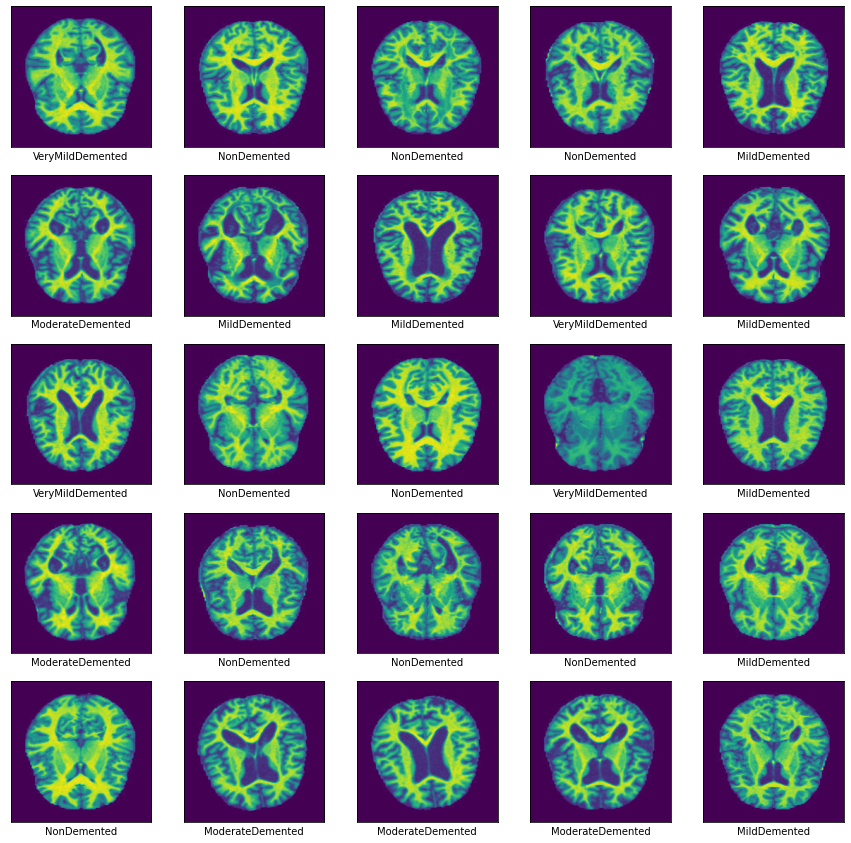

In [ ]:
class_names = ['NonDemented','ModerateDemented','MildDemented','VeryMildDemented']
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i].reshape(200,200))
    plt.xlabel(class_names[y_train[i]])
  

A continuación se visualizara el numero de imágenes por cada clase. 

In [ ]:
print( "  clase   # de imágenes")
for i in np.unique(y_train):
    print( "   ",int(i), "       ", np.sum(y_train==i))

  clase   # de imágenes
    0         2560
    1         2184
    2         1434
    3         1792


In [ ]:
print( "  clase   # de imágenes")
for i in np.unique(y_train_Original):
    print( "   ",int(i), "       ", np.sum(y_train_Original==i))

  clase   # de imágenes
    0         2560
    1         52
    2         717
    3         1792


<br><br>
<h3> En este momento realizaremos la carga de la parte de testeo del dataset <h3>

In [ ]:
loadtest = '/content/drive/My Drive/ProyectoInteligencia/Alzheimer_s Dataset/test/NonDemented'
test = os.listdir(loadtest)

#creamos dos listas para empezar a guardar las imagenes 
X_test = [] #lista con imágenes de test
y_test = []
X_test_Original = [] #lista con imágenes de test
y_test_Original = []

for j in test:
  img_t = cv2.imread(loadtest +'/'+j)
  img_t = cv2.resize(img_t, dim)
  gray_t = cv2.cvtColor(img_t, cv2.COLOR_BGR2GRAY)  
  X_test.append(gray_t.flatten()) 
  y_test.append(0)  #0 NonDemented 
  X_test_Original.append(gray_t.flatten()) 
  y_test_Original.append(0)  #0 NonDemented

<br>
<h3>Al tener tan pocas imagenes de la siguiente clase se procedera a rotarlas y reflejarlas para que no haya tanto desbalance de clases y pueda funcionar de una mejor manera.</h3>
<br>

In [ ]:
loadtest = '/content/drive/My Drive/ProyectoInteligencia/Alzheimer_s Dataset/test/ModerateDemented'
test = os.listdir(loadtest)
F=0
temp=[]
for k in test:
  F=F+1
  img_t = cv2.imread(loadtest +'/'+k)
  img_t = cv2.resize(img_t, dim)
  gray_t = cv2.cvtColor(img_t, cv2.COLOR_BGR2GRAY)  
  temp.append(gray_t)
  X_test.append(gray_t.flatten()) 
  y_test.append(1)  #1 ModerateDemented
  X_test_Original.append(gray_t.flatten()) 
  y_test_Original.append(1)  #1 ModerateDemented

#EFECTO ESPEJO
  imagenEspejo=np.fliplr(gray_t)
  X_test.append(imagenEspejo.flatten()) #guarda la imagen en la lista 
  y_test.append(1)  #1 ModerateDemented

#ROTACIÓN
width=200
height=200

for j in range(F):
  for k in range(20):
    rotationMatrix = cv2.getRotationMatrix2D((width/2, height/2), k/2, 1)
    rotationMatrix2 = cv2.getRotationMatrix2D((width/2, height/2), -k/2, 1)

    rotatedImage = cv2.warpAffine(temp[j], rotationMatrix, (width, height))
    rotatedImage2 = cv2.warpAffine(temp[j], rotationMatrix, (width, height))

    X_test.append(rotatedImage.flatten())
    X_test.append(rotatedImage2.flatten())

    y_test.append(1)  #1 ModerateDemented
    y_test.append(1)  #1 ModerateDemented

In [ ]:
loadtest = '/content/drive/My Drive/ProyectoInteligencia/Alzheimer_s Dataset/test/MildDemented'
test = os.listdir(loadtest)

for j in test:
  img_t = cv2.imread(loadtest +'/'+j)
  img_t = cv2.resize(img_t, dim)
  gray_t = cv2.cvtColor(img_t, cv2.COLOR_BGR2GRAY)  
  X_test.append(gray_t.flatten()) 
  y_test.append(2)  #2 MildDemented
  X_test_Original.append(gray_t.flatten()) 
  y_test_Original.append(2)  #2 MildDemented

  #EFECTO ESPEJO
  imagenEspejo=np.fliplr(gray_t)
  X_test.append(imagenEspejo.flatten()) #guarda la imagen en la lista 
  y_test.append(2)  #2 MildDemented

In [ ]:
loadtest = '/content/drive/My Drive/ProyectoInteligencia/Alzheimer_s Dataset/test/VeryMildDemented'
test = os.listdir(loadtest)

for j in test:
  img_t = cv2.imread(loadtest +'/'+j)
  img_t = cv2.resize(img_t, dim)
  gray_t = cv2.cvtColor(img_t, cv2.COLOR_BGR2GRAY)  
  X_test.append(gray_t.flatten()) 
  y_test.append(3)  #3 VeryMildDemented
  X_test_Original.append(gray_t.flatten()) 
  y_test_Original.append(3)  #3 VeryMildDemented

**Permutación**
<br>
<h2>Para poder realizar las estimaciones necesitaremos permutar los datos de test.</h2>
<br>

In [ ]:
perm_t = np.random.permutation(range(len(X_test)))
X_test=np.r_[X_test]
y_test=np.r_[y_test]
X_test=X_test[perm_t]
y_test=y_test[perm_t]
print(X_test.shape)

(1950, 40000)


In [ ]:
perm_t_Original = np.random.permutation(range(len(X_test_Original)))
X_test_Original=np.r_[X_test_Original]
y_test_Original=np.r_[y_test_Original]
X_test_Original=X_test_Original[perm_t_Original]
y_test_Original=y_test_Original[perm_t_Original]
print(X_test_Original.shape)

(1279, 40000)


Shape de los dos test y su clasificación

In [ ]:
print( "  clase   # de imágenes")
for i in np.unique(y_test):
    print( "   ",int(i), "       ", np.sum(y_test==i))

  clase   # de imágenes
    0         640
    1         504
    2         358
    3         448


In [ ]:
print( "  clase   # de imágenes")
for i in np.unique(y_test_Original):
    print( "   ",int(i), "       ", np.sum(y_test_Original==i))

  clase   # de imágenes
    0         640
    1         12
    2         179
    3         448


<br><br>

<h1> Utilizaremos los métodos que vimos para decicidir cual será el mejor</h1>


**<h2>Gaussian NB Original</h2>**

In [ ]:
g_O = GaussianNB()
g_O.fit(X_train_Original, y_train_Original)
sG_O = cross_val_score(g_O, X_test_Original, y_test_Original, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(sG_O), np.std(sG_O)))
print( "acierto en train", g_O.score(X_train_Original, y_train_Original))
print( "acierto en test ", g_O.score(X_test_Original, y_test_Original))


accuracy 0.526 (+/- 0.02182)
acierto en train 0.568638937707479
acierto en test  0.5340109460516028


**<h2>Gaussian NB</h2>**

In [ ]:
g = GaussianNB()
g.fit(X_train, y_train)
sG = cross_val_score(g, X_test, y_test, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(sG), np.std(sG)))
print( "acierto en train", g.score(X_train, y_train))
print( "acierto en test ", g.score(X_test, y_test))

accuracy 0.674 (+/- 0.02402)
acierto en train 0.6933500627352572
acierto en test  0.676923076923077


<br><br> <h2> **SVC Original**

In [ ]:
svc_O = SVC()
svc_O.fit(X_train_Original, y_train_Original)
score_O = cross_val_score(svc_O, X_test_Original, y_test_Original, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))

In [ ]:
print("accuracy score: %.3f (+/- %.5f)"%(np.mean(score_O ), np.std(score_O )))

accuracy score: 0.658 (+/- 0.03931)


<br><br> <h2> **SVC**

In [ ]:
svc = SVC()
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
print( "acierto en train", svc.score(X_train, y_train))
print( "acierto en test ", svc.score(X_test, y_test))

acierto en train 0.914930991217064
acierto en test  0.5707692307692308


In [ ]:
predicciones_train = svc.predict(X_train)
predicciones_test  = svc.predict(X_test)

<h3>Presentaremos la matriz de confusión para una mejor visualización de las probabilidades</h3>

In [ ]:
score = cross_val_score(svc, X_test, y_test, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
cm_train = confusion_matrix(y_train, predicciones_train)
cm_test = confusion_matrix(y_test, predicciones_test)
print( "matrix de confusión en train\n", cm_train)
print("matrix de confusión en test\n", cm_test)
print( "verifica número de imágenes en total por fila")
print( np.sum(cm_test, axis=1))
print("accuracy score: %.3f (+/- %.5f)"%(np.mean(score), np.std(score)))

matrix de confusión en train
 [[2469    0    0   91]
 [   0 2170   14    0]
 [ 103    0 1180  151]
 [ 318    0    1 1473]]
matrix de confusión en test
 [[568   0   0  72]
 [155 228   3 118]
 [128   0 140  90]
 [270   0   1 177]]
verifica número de imágenes en total por fila
[640 504 358 448]
accuracy score: 0.790 (+/- 0.02696)


<br><br> <h2> **Decision Tree Classifier Original**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
estDT_O = DecisionTreeClassifier()
estDT_O.fit(X_train_Original, y_train_Original)
sDT_O = cross_val_score(estDT_O, X_test_Original, y_test_Original, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(sDT_O), np.std(sDT_O)))


accuracy 0.721 (+/- 0.02408)


<br><br> <h2> **Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
estDT = DecisionTreeClassifier(max_depth=60)
estDT.fit(X_train, y_train)
estDT.predict(X_test)
sDT = cross_val_score(estDT, X_test, y_test, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(sDT), np.std(sDT)))

accuracy 0.842 (+/- 0.02252)


<br><br> <h2> **Random Forest Original**

In [ ]:
estRF_O = RandomForestClassifier()
estRF_O.fit(X_train_Original, y_train_Original)
srf_O = cross_val_score(estRF_O, X_test_Original, y_test_Original, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(srf_O), np.std(srf_O)))


accuracy 0.924 (+/- 0.03461)


<br><br> <h2> **Random Forest**

In [ ]:
estRF = RandomForestClassifier()
estRF.fit(X_train, y_train)
predicciones = estRF.predict(X_test)
srf = cross_val_score(estRF, X_test, y_test, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(srf), np.std(srf)))

accuracy 0.951 (+/- 0.00888)


<br><br> <h2> **Pipeline Original**

In [ ]:
p_O = Pipeline((("pca", PCA(n_components=50)), ("classifier", SVC(kernel='rbf')) ))
sp_O = cross_val_score(p_O, X_test_Original, y_test_Original, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print( "accuracy %.3f (+/- %.5f)"%(np.mean(sp_O), np.std(sp_O)))


accuracy 0.868 (+/- 0.01395)


<br><br> <h2> **Pipeline**

In [ ]:

p = Pipeline((("pca", PCA(n_components=50)), ("classifier", SVC(kernel='rbf')) ))
sp = cross_val_score(p, X_test, y_test, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print( "accuracy %.3f (+/- %.5f)"%(np.mean(sp), np.std(sp)))

accuracy 0.885 (+/- 0.01181)


<br><br><br><br>
<h1> Red neuronal Original</h1>

In [ ]:
class_names = ['NonDemented','ModerateDemented','MildDemented','VeryMildDemented']
NUM_CLASSES = len(class_names)

<h3>En esta apartado utilizaremos el Layers Dense para crear la red neuronal ya que nuestras imagenes han sido modificada mediante la función Flatten, por lo tanto solo utilizaremos un Layer con el shape que podemos visualizar</h3>

In [ ]:
def create_model_O():
  model_O = keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train_Original[0].shape), #1 capa flatten aplane mi entrada
    tf.keras.layers.Dense(1000, activation=tf.nn.relu),
    tf.keras.layers.Dense(500, activation=tf.nn.relu),
    tf.keras.layers.Dense(250, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax) # capa de salida 
  ])
  model_O.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  model_O.summary()
  return model_O

<h3>Aca se utiliza la red neuronal anteriormente establecida</h3>

In [ ]:
modelo_O= None
modelo_O= create_model_O()
history_O = modelo_O.fit(X_train_Original, y_train_Original, epochs=20, batch_size=100, validation_data=(X_test_Original,y_test_Original))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              40001000  
_________________________________________________________________
dense_6 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_7 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32128     
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 516       
Total params: 40,659,394
Trainable params: 40,659,394
Non-trainable params: 0
__________________________________________

<br><br><br><br>
<h1> Red neuronal Data Aumentation</h1>

<h3>En esta apartado utilizaremos el Layers Dense para crear la red neuronal ya que nuestras imagenes han sido modificada mediante la función Flatten, por lo tanto solo utilizaremos un Layer con el shape que podemos visualizar</h3>

In [ ]:
def create_model():
  model = keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train[0].shape), #1 capa flatten aplane mi entrada
    tf.keras.layers.Dense(1000, activation=tf.nn.relu),
    tf.keras.layers.Dense(500, activation=tf.nn.relu),
    tf.keras.layers.Dense(250, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax) # capa de salida 
  ])
  model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  model.summary()
  return model


<h3>Aca se utiliza la red neuronal anteriormente establecida</h3>

In [ ]:
modelo= None
modelo= create_model()
history = modelo.fit(X_train, y_train, epochs=20, batch_size=100, validation_data=(X_test,y_test))
test_loss, test_acc = modelo.evaluate(X_test, y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
dense (Dense)                (None, 1000)              40001000  
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32128     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
Total params: 40,659,394
Trainable params: 40,659,394
Non-trainable params: 0
____________________________________________

<h3>Aca podemos observar el comportamiento de la red neuronal mediante una grafica</h3>

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


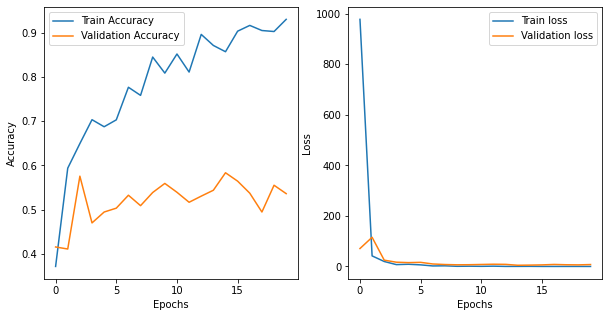

In [ ]:
print(history.history.keys())
fig = plt.figure(figsize = (10,5))
ax= fig.add_subplot(1,2,1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1,2,2)
ax.plot(history.history['loss'], label='Train loss');
ax.plot(history.history['val_loss'], label='Validation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

<h3>Aca observamos la comparación de cada uno de los estimadores utilizados en el caso de aumento de los datos.</h3>

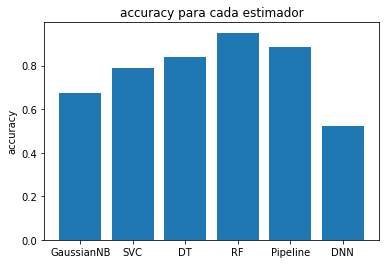

In [ ]:
estimadores = ["GaussianNB", "SVC", "DT", "RF", "Pipeline", "DNN"] 
accuracy = [np.mean(sG), np.mean(score),np.mean(sDT), np.mean(srf), np.mean(sp), np.mean(history.history['val_accuracy'])]
fig, ax = plt.subplots()
ax.set_ylabel('accuracy')
ax.set_title('accuracy para cada estimador')
plt.bar(estimadores, accuracy)
plt.show()


<br><br><h3>En la siguiente gráfica realizamos una comparación del accuracy de diferentes estimadores entre las imágenes dadas en el dataset, y las agragadas mediante Data Aumentation.<h3><br>



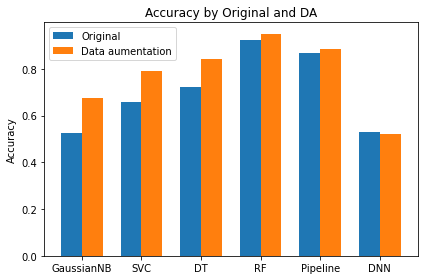

In [ ]:
# @title Código gráfica barras
labels = ["GaussianNB", "SVC", "DT", "RF", "Pipeline", "DNN"]
acc_O = [np.mean(sG_O), np.mean(score_O), np.mean(sDT_O),np.mean(srf_O), np.mean(sp_O), np.mean(history_O.history['val_accuracy'])]
acc_M = [np.mean(sG), np.mean(score),np.mean(sDT),np.mean(srf),np.mean(sp),np.mean(history.history['val_accuracy'])]

x = np.arange(len(labels))  # labels
width = 0.35  # anchura de las barras

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, acc_O, width, label='Original')
rects2 = ax.bar(x + width/2, acc_M, width, label='Data aumentation')

# 
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Original and DA')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

<br><br> <h2> A continuación haremos una prueba mediante unas predicciones utilizando el mejor estimador encontrado </h2> <br>

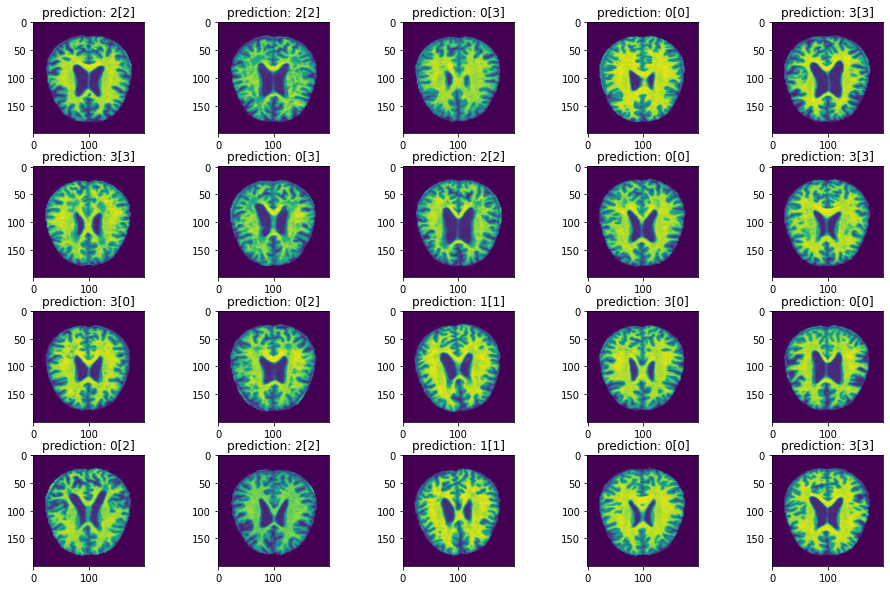

In [ ]:
plt.figure(1, figsize=(16,10))
n=0
for i in range(20):
  n += 1
  r = np.random.randint(0, X_test.shape[0], 1)
  plt.subplot(4, 5, n) #numero de filas y cantidad de columnas de la grafica
  plt.subplots_adjust(hspace = 0.3, wspace =0.2)
  plt.imshow(np.squeeze(X_test[r].reshape(200,200)))
  plt.title("prediction: "+str(int(estRF.predict(X_test[r]))) + str(y_test[r]))
plt.show()